In [ ]:
import torch

print("PyTorch Version : {}".format(torch.__version__))

In [ ]:
import torchtext

print("Torch Text Version : {}".format(torchtext.__version__))

In [ ]:
# uncomment bellow to install dependences

# !pip install portalocker>=2.0.0
# !pip install scikit-plot
# !pip install scipy==1.11.4
# !pip install lime

In [3]:
from torch.utils.data import DataLoader

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

target_classes = ["World", "Sports", "Business", "Sci/Tec"]

In [32]:
type(train_dataset)

torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe

In [4]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [5]:
len(vocab.get_itos())

98635

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

vectorizer = CountVectorizer(vocabulary=vocab.get_itos(), tokenizer=tokenizer)

def vectorize_batch(batch):
    Y, X = list(zip(*batch)) # agrupa labels em uma tupla e textos em outra tupla (exemplo abaixo)
    X = vectorizer.transform(X).todense()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=256, collate_fn=vectorize_batch)

In [7]:
arr = [[1, 'teste'], [2, 'teste2']]

_y, _x = list(zip(*arr))

arr, *arr, _y, _x 

([[1, 'teste'], [2, 'teste2']],
 [1, 'teste'],
 [2, 'teste2'],
 (1, 2),
 ('teste', 'teste2'))

In [8]:
counter = 0
max_count = 10

for x, y in train_dataset:
    print(x, target_classes[x - 1], ' - ', y)
    if counter == max_count:
        break
    counter = counter + 1

3 Business  -  Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
3 Business  -  Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
3 Business  -  Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3 Business  -  Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
3 Business  -  Oil prices soar to all-

In [9]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([256, 98635]) torch.Size([256])


In [10]:
from torch import nn
from torch.nn import functional as F

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(len(vocab), 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4),
            #nn.ReLU(),

            #nn.Linear(64, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [11]:
text_classifier = TextClassifier()
for X, Y in train_loader:
    Y_preds = text_classifier(X)
    print(Y_preds.shape)
    break

torch.Size([256, 4])


In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [13]:
from torch.optim import Adam

epochs = 8
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = TextClassifier()
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


Train Loss : 0.786
Valid Loss : 0.358
Valid Acc  : 0.896


100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


Train Loss : 0.283
Valid Loss : 0.279
Valid Acc  : 0.914


100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


Train Loss : 0.212
Valid Loss : 0.257
Valid Acc  : 0.916


100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


Train Loss : 0.171
Valid Loss : 0.248
Valid Acc  : 0.917


100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


Train Loss : 0.140
Valid Loss : 0.246
Valid Acc  : 0.918


100%|██████████| 469/469 [00:58<00:00,  8.04it/s]


Train Loss : 0.116
Valid Loss : 0.248
Valid Acc  : 0.918


100%|██████████| 469/469 [00:58<00:00,  8.03it/s]


Train Loss : 0.096
Valid Loss : 0.255
Valid Acc  : 0.918


100%|██████████| 469/469 [00:58<00:00,  7.97it/s]


Train Loss : 0.079
Valid Loss : 0.265
Valid Acc  : 0.917


In [14]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(text_classifier, test_loader)

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9172368421052631

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.92      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.89      0.88      1900
     Sci/Tec       0.91      0.88      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix : 
[[1751   46   64   39]
 [  23 1859   12    6]
 [  79   13 1693  115]
 [  59   14  159 1668]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tec'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

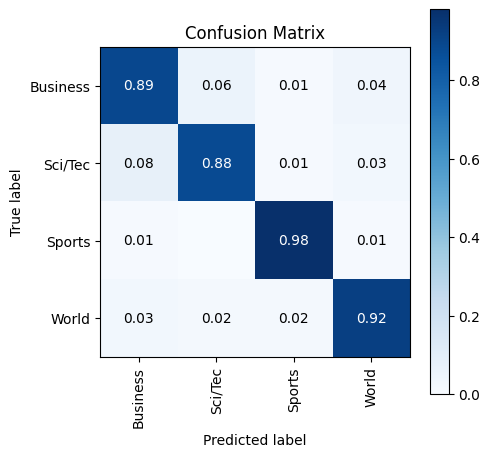

In [16]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    )
plt.xticks(rotation=90)

In [17]:
from lime import lime_text

explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

In [18]:
import numpy as np

## Retrieve test documents.
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

## Function to make prediction from text data
def make_predictions(X_batch_text):
    X_batch_vect = vectorizer.transform(X_batch_text).todense()
    logits = text_classifier(torch.tensor(X_batch_vect, dtype=torch.float32))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().numpy()

## Randomly select test example for explanation
rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))

X_batch_vect = vectorizer.transform(X_test_text[idx:idx+1]).todense()
logits = text_classifier(torch.tensor(X_batch_vect, dtype=torch.float32))
preds = F.softmax(logits, dim=-1)

print("Prediction : ", target_classes[preds.argmax(axis=-1)[0]])
print("Actual :     ", target_classes[Y_test[idx]])



Prediction :  Business
Actual :      Business
